In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from scipy.stats import gaussian_kde

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import random
import gc 
# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 100
pd.options.display.max_columns = 1000

# 前のnotebookの関数達

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)
    
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    column_names = []
    for var in categorical.columns.levels[0]:
            for stat in ['count', 'count_norm']:
                column_names.append('%s_%s_%s' % (df_name, var, stat))
    categorical.columns = column_names
    return categorical

def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

def agg_numeric(df, parent_var, df_name):
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    columns = []

    for var in agg.columns.levels[0]:
        if var != parent_var:
            for stat in agg.columns.levels[1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
def remove_missing_columns(train, test, threshold = 90):
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    return train, test

def agg_categorical(df, parent_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))

    categorical[parent_var] = df[parent_var]

    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    for var in categorical.columns.levels[0]:
        for stat in ['sum', 'count', 'mean']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

def feature_importance_plot(df):
    a = df[["Feature_fold1","Importance_fold1"]]
    b = df[["Feature_fold2","Importance_fold2"]].rename(columns={"Feature_fold2":"Feature_fold1", "Importance_fold2":"Importance_fold1"})
    c = df[["Feature_fold3","Importance_fold3"]].rename(columns={"Feature_fold3":"Feature_fold1", "Importance_fold3":"Importance_fold1"})
    d = df[["Feature_fold4","Importance_fold4"]].rename(columns={"Feature_fold4":"Feature_fold1", "Importance_fold4":"Importance_fold1"})
    # e = df[["Feature_fold5","Importance_fold5"]].rename(columns={"Feature_fold5":"Feature_fold1", "Importance_fold5":"Importance_fold1"})
    
    feat = pd.concat([a, b, c, d]).reset_index()
    indices = feat.groupby("Feature_fold1")["Importance_fold1"].agg("mean").reset_index().sort_values("Importance_fold1", ascending=False)[["Feature_fold1",'Importance_fold1']]
    plt.figure(figsize=(10,14))
    plt.title("重要度上位50")
    sns.barplot(x="Importance_fold1", y="Feature_fold1", data=feat, order=indices.iloc[:50, 0])
    return indices

In [3]:
import sys

# データが何GBかを指す
def return_size(df):
    return round(sys.getsizeof(df) / 1e9, 2)

# データを軽くする
def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    for c in df:
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)       
    new_memory = df.memory_usage().sum()
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')   
        print(df.shape)
    return df

In [4]:
POS_CASH_balance = pd.read_pickle('../home credit/POS_CASH_balance.pickle')
bureau_balance = pd.read_pickle('../home credit/bureau_balance.pickle')
application_train = pd.read_pickle('../home credit/application_train.pickle')
previous_application = pd.read_pickle('../home credit/previous_application.pickle')
installments_payments = pd.read_pickle('../home credit/installments_payments.pickle')
credit_card_balance = pd.read_pickle('../home credit/credit_card_balance.pickle')
application_test = pd.read_pickle('../home credit/application_test.pickle')
bureau = pd.read_pickle('../home credit/bureau.pickle')
description = pd.read_csv('../home credit/HomeCredit_columns_description.csv', index_col=0).iloc[:,0:5]
train_bureau_corrs_removed = pd.read_pickle('../home credit/train_bureau_corrs_removed.pkl')
test_bureau_corrs_removed = pd.read_pickle('../home credit/test_bureau_corrs_removed.pkl')
pd.options.display.max_colwidth = 20000
def search_description(column):
    return description.loc[description.Row == column][['Description','日本語訳']]

# credit

In [15]:
credit_card_balance.head(100)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.500000,0.0,877.500000,1700.324951,1800.000000,1800.000000,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.000000,0.0,0.000000,2250.000000,2250.000000,2250.000000,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.000000,0.0,0.000000,2250.000000,2250.000000,2250.000000,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.000000,0.0,0.000000,11795.759766,11925.000000,11925.000000,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.000000,0.0,11547.000000,22924.890625,27000.000000,27000.000000,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.812500,270000,0.0,0.000000,0.0,0.000000,4449.104980,3825.000000,3825.000000,80519.039062,82773.312500,82773.312500,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.656250,585000,67500.0,67500.000000,0.0,0.000000,14684.174805,15750.000000,15750.000000,345433.875000,351881.156250,351881.156250,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125000,45000,45000.0,45000.000000,0.0,0.000000,0.000000,264.690002,0.000000,44735.308594,47962.125000,47962.125000,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.062500,292500,90000.0,289339.437500,0.0,199339.421875,130.500000,4093.514893,4093.514893,285376.406250,286831.562500,286831.562500,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.187500,225000,76500.0,111026.703125,0.0,34526.699219,6338.339844,45000.000000,45000.000000,192793.281250,197224.687500,197224.687500,3.0,9,0.0,6.0,38.0,Active,0,0


In [12]:
credit_card_balance.query('SK_ID_PREV == 1389973').sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2205888,1389973,337855,-15,12286.125000,45000,0.0,12286.125000,0.0,12286.125000,0.000000,NaN,0.000000,12286.125000,12286.125000,12286.125000,0.0,1,0.0,1.0,0.0,Active,0,0
632892,1389973,337855,-14,37020.058594,45000,0.0,26309.250000,0.0,26309.250000,0.000000,2250.000000,0.000000,37020.058594,37020.058594,37020.058594,0.0,4,0.0,4.0,0.0,Active,0,0
2450591,1389973,337855,-13,46664.773438,225000,0.0,8287.514648,0.0,8287.514648,2250.000000,595.304993,595.304993,44712.269531,45880.066406,45880.066406,0.0,4,0.0,4.0,1.0,Active,0,0
1520477,1389973,337855,-12,161371.796875,225000,13500.0,113164.601562,0.0,99664.601562,2295.584961,3029.129883,3029.129883,156709.843750,158542.468750,158542.468750,3.0,30,0.0,27.0,2.0,Active,0,0
3795788,1389973,337855,-11,235819.984375,225000,13500.0,72448.289062,0.0,58948.289062,7017.750000,8792.684570,8792.684570,224704.125000,229646.343750,229646.343750,3.0,23,0.0,20.0,3.0,Active,0,0
3000084,1389973,337855,-10,235948.187500,225000,1350.0,2852.550049,0.0,1502.550049,11504.924805,13192.650391,13192.650391,224766.906250,232436.296875,232436.296875,1.0,3,0.0,2.0,4.0,Active,0,0
2642364,1389973,337855,-9,233909.812500,225000,0.0,2002.500000,0.0,2002.500000,11670.974609,11804.669922,11804.669922,224894.468750,231732.625000,231732.625000,0.0,2,0.0,2.0,5.0,Active,0,0
3017411,1389973,337855,-8,229996.343750,225000,0.0,0.000000,0.0,0.000000,11641.049805,11765.610352,11765.610352,221054.984375,227848.718750,227848.718750,0.0,0,0.0,0.0,6.0,Active,0,0
2208754,1389973,337855,-7,226194.125000,225000,0.0,0.000000,0.0,0.000000,11436.434570,11475.000000,11475.000000,217253.750000,224075.796875,224075.796875,0.0,0,0.0,0.0,7.0,Active,0,0
2563691,1389973,337855,-6,237884.125000,225000,11250.0,11250.000000,0.0,0.000000,11247.434570,11250.000000,11250.000000,224948.296875,231670.031250,231670.031250,3.0,3,0.0,0.0,8.0,Active,0,0


In [17]:
credit_card_balance.query('SK_ID_PREV == 1039039').sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2250996,1039039,276642,-96,0.000000,67500,0.0,0.0,0.0,0.0,581.039978,1774.214966,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
317889,1039039,276642,-95,0.000000,67500,0.0,0.0,0.0,0.0,0.000000,1193.175049,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
449377,1039039,276642,-94,0.000000,67500,0.0,0.0,0.0,0.0,0.000000,1193.175049,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
3351706,1039039,276642,-93,0.000000,67500,0.0,0.0,0.0,0.0,0.000000,1193.175049,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
2518866,1039039,276642,-92,0.000000,67500,0.0,0.0,0.0,0.0,0.000000,1193.175049,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
1702154,1039039,276642,-91,0.000000,67500,0.0,0.0,0.0,0.0,0.000000,1193.175049,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
1540974,1039039,276642,-90,0.000000,67500,0.0,0.0,0.0,0.0,0.000000,1193.175049,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
39504,1039039,276642,-89,0.000000,67500,0.0,0.0,0.0,0.0,0.000000,1193.175049,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,6.0,Active,0,0
3190169,1039039,276642,-88,67364.820312,67500,67500.0,67500.0,0.0,0.0,0.000000,1193.175049,0.000000,66306.828125,67364.820312,67364.820312,2.0,2,0.0,0.0,6.0,Active,0,0
1508435,1039039,276642,-87,68780.968750,67500,67500.0,67500.0,0.0,0.0,3375.000000,68490.000000,68490.000000,66374.820312,68780.968750,68780.968750,3.0,3,0.0,0.0,7.0,Active,0,0


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

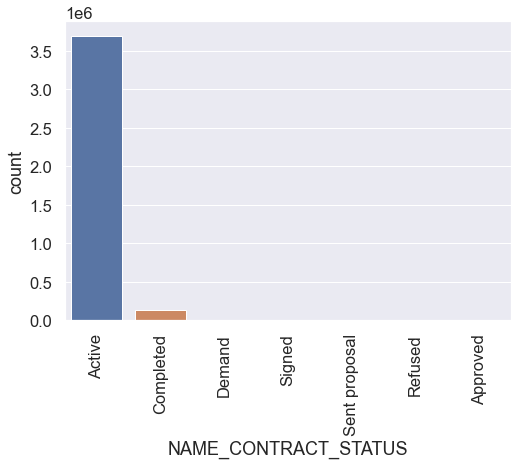

In [26]:
sns.countplot('NAME_CONTRACT_STATUS', data=credit_card_balance)
plt.xticks(rotation=90)

In [27]:
Refused = credit_card_balance[credit_card_balance['NAME_CONTRACT_STATUS'] == 'Refused']
Demand = credit_card_balance[credit_card_balance['NAME_CONTRACT_STATUS'] == 'Demand']
Approved = credit_card_balance[credit_card_balance['NAME_CONTRACT_STATUS'] == 'Approved']
Sent_proposal = credit_card_balance[credit_card_balance['NAME_CONTRACT_STATUS'] == 'Sent proposal']
Signed = credit_card_balance[credit_card_balance['NAME_CONTRACT_STATUS'] == 'Signed']

# NAME_CONTRACT_STATUS

結論として、Sent_proposal, Approved, Signed, Refusedは一番初めに出てくる。

## Refused

In [28]:
Refused

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
301915,1282349,371555,-91,0.0,90000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Refused,0,0
483042,2494884,204816,-86,0.0,90000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Refused,0,0
892792,2148924,416141,-80,0.0,157500,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Refused,0,0
1164415,1910523,305461,-91,0.0,157500,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Refused,0,0
1373074,1945736,400042,-86,0.0,157500,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Refused,0,0
1440103,1295364,150137,-80,0.0,90000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Refused,0,0
1475978,1030684,208890,-73,0.0,135000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Refused,0,0
1479957,1195453,428210,-81,0.0,135000,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Refused,0,0
1586866,1211141,451837,-89,0.0,90000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Refused,0,0
1641811,1207737,102367,-85,0.0,135000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Refused,0,0


In [30]:
credit_card_balance.query('SK_ID_PREV == 1945736').sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1373074,1945736,400042,-86,0.000000,157500,NaN,0.0,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,NaN,0,NaN,NaN,NaN,Refused,0,0
1034278,1945736,400042,-85,89886.960938,157500,90000.0,90000.0,0.0,0.0,NaN,2250.000000,2250.0,87750.000000,89886.960938,89886.960938,2.0,2,0.0,0.0,NaN,Active,0,0
1255802,1945736,400042,-84,87394.406250,157500,0.0,0.0,0.0,0.0,4500.000000,4500.000000,4500.0,85386.960938,87394.406250,87394.406250,0.0,0,0.0,0.0,1.0,Active,0,0
446244,1945736,400042,-83,84867.210938,157500,0.0,0.0,0.0,0.0,4500.000000,4500.000000,4500.0,82894.406250,84867.210938,84867.210938,0.0,0,0.0,0.0,2.0,Active,0,0
398834,1945736,400042,-82,82351.531250,157500,0.0,0.0,0.0,0.0,4500.000000,4500.000000,4500.0,80367.210938,82351.531250,82351.531250,0.0,0,0.0,0.0,3.0,Active,0,0
1050489,1945736,400042,-81,150522.296875,157500,67500.0,67500.0,0.0,0.0,4500.000000,4500.000000,4500.0,145351.531250,150522.296875,150522.296875,2.0,2,0.0,0.0,4.0,Active,0,0
1774722,1945736,400042,-80,148364.812500,157500,0.0,0.0,0.0,0.0,7875.000000,7875.000000,7875.0,142647.296875,148364.812500,148364.812500,0.0,0,0.0,0.0,5.0,Active,0,0
2792237,1945736,400042,-79,146220.703125,157500,0.0,0.0,0.0,0.0,7875.000000,7875.000000,7875.0,140489.812500,146220.703125,146220.703125,0.0,0,0.0,0.0,6.0,Active,0,0
665183,1945736,400042,-78,143933.625000,157500,0.0,0.0,0.0,0.0,7875.000000,7875.000000,7875.0,138345.703125,143933.625000,143933.625000,0.0,0,0.0,0.0,7.0,Active,0,0
236283,1945736,400042,-77,141688.031250,157500,0.0,0.0,0.0,0.0,7875.000000,7875.000000,7875.0,136058.625000,141688.031250,141688.031250,0.0,0,0.0,0.0,8.0,Active,0,0


## Demand

In [31]:
Demand

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
4399,1263695,306464,-7,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,22.0,Demand,0,0
5314,1944495,282554,-13,0.000000,67500,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,43.0,Demand,0,0
5315,1514682,337884,-18,0.000000,67500,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,43.0,Demand,0,0
16999,2552380,441297,-25,89930.117188,90000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,89930.117188,98328.734375,106727.351562,0.0,0,0.0,0.0,19.0,Demand,1158,1158
17164,2709729,431114,-50,111186.046875,90000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,90000.000000,109206.046875,110466.046875,0.0,0,0.0,0.0,7.0,Demand,1007,1007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832865,2452557,144024,-24,157476.593750,180000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,157476.593750,180574.203125,203671.796875,0.0,0,0.0,0.0,24.0,Demand,1735,1735
3834388,2031153,250407,-33,0.000000,90000,0.0,0.0,0.0,0.0,0.0,1.35,0.0,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,43.0,Demand,0,0
3836488,1944495,282554,-26,0.000000,67500,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,43.0,Demand,0,0
3836489,1514682,337884,-31,0.000000,67500,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,43.0,Demand,0,0


In [38]:
credit_card_balance.query('SK_ID_PREV == 2452557').sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
783778,2452557,144024,-96,183569.718750,180000,20250.0,20250.0,0.0,0.0,9000.000000,9000.000000,9000.000000,176281.562500,183569.718750,183569.718750,3.0,3,0.0,0.0,7.0,Active,0,0
571386,2452557,144024,-95,180111.687500,180000,0.0,0.0,0.0,0.0,9000.000000,9000.000000,9000.000000,174569.718750,180111.687500,180111.687500,0.0,0,0.0,0.0,8.0,Active,0,0
318807,2452557,144024,-94,190744.421875,180000,4500.0,4500.0,0.0,0.0,9000.000000,0.000000,0.000000,179069.718750,190744.421875,190744.421875,1.0,1,0.0,0.0,9.0,Active,1,1
2129736,2452557,144024,-93,178294.546875,180000,0.0,0.0,0.0,0.0,9000.000000,18000.000000,18000.000000,172744.421875,180814.546875,183334.546875,0.0,0,0.0,0.0,10.0,Active,0,0
2381055,2452557,144024,-92,172779.531250,180000,0.0,0.0,0.0,0.0,9000.000000,13500.000000,13500.000000,167314.546875,172779.531250,172779.531250,0.0,0,0.0,0.0,11.0,Active,0,0
2363214,2452557,144024,-91,169083.187500,180000,0.0,0.0,0.0,0.0,9000.000000,9000.000000,9000.000000,163779.531250,169083.187500,169083.187500,0.0,0,0.0,0.0,12.0,Active,0,0
602010,2452557,144024,-90,182524.812500,180000,6750.0,6750.0,0.0,0.0,9000.000000,0.000000,0.000000,170529.531250,182524.812500,182524.812500,2.0,2,0.0,0.0,13.0,Active,1,1
793796,2452557,144024,-89,180904.906250,180000,9000.0,9000.0,0.0,0.0,9000.000000,18000.000000,18000.000000,173524.812500,180904.906250,180904.906250,3.0,3,0.0,0.0,14.0,Active,0,0
2886882,2452557,144024,-88,193629.062500,180000,5850.0,5850.0,0.0,0.0,9000.000000,0.000000,0.000000,179374.812500,193629.062500,193629.062500,2.0,2,0.0,0.0,15.0,Active,1,1
2824984,2452557,144024,-87,190215.718750,180000,0.0,0.0,0.0,0.0,9000.000000,9000.000000,9000.000000,179374.812500,190215.718750,190215.718750,0.0,0,0.0,0.0,16.0,Active,1,1


In [39]:
application_train.query('SK_ID_CURR == 144024')

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
38012,144024,1,Cash loans,F,N,Y,1,247500.0,391500.0,20119.5,391500.0,Unaccompanied,Commercial associate,Higher education,Single / not married,Co-op apartment,0.006851,-14906,-5362,-9000.0,-2533,NaN,1,1,0,1,0,0,Managers,2.0,3,3,TUESDAY,14,0,0,0,0,0,0,Business Entity Type 3,NaN,0.664062,0.408447,0.08252,0.087402,0.97998,0.728027,0.063599,0.0,0.137939,0.166748,0.0,0.062988,0.0672,0.075989,0.0,0.0,0.083984,0.090698,0.97998,0.73877,0.064209,0.0,0.137939,0.166748,0.0,0.064514,0.073486,0.079102,0.0,0.0,0.083313,0.087402,0.97998,0.731445,0.064026,0.0,0.137939,0.166748,0.0,0.064087,0.06842,0.077271,0.0,0.0,reg oper account,block of flats,0.097595,Panel,No,0.0,0.0,0.0,0.0,-759.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


## Approved

In [40]:
Approved

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
367717,2523756,418748,-93,0.0,135000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Approved,0,0
964547,2536057,243608,-94,0.0,135000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Approved,0,0
2685073,2672079,145687,-89,0.0,180000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Approved,0,0
3452462,1469279,291719,-95,0.0,247500,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Approved,0,0
3648444,2038867,391845,-85,0.0,157500,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Approved,0,0


In [46]:
credit_card_balance.query('SK_ID_PREV == 1469279').sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3452462,1469279,291719,-95,0.000000,247500,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,NaN,NaN,NaN,Approved,0,0
2731996,1469279,291719,-94,81671.671875,247500,1350.0,83353.500000,50985.0,31018.500000,NaN,4500.000000,4500.000000,78853.500000,81671.671875,81671.671875,1.0,3,1.0,1.0,NaN,Signed,0,0
2945856,1469279,291719,-93,78465.914062,247500,0.0,1035.000000,0.0,1035.000000,4500.000000,6750.000000,6750.000000,75956.671875,78465.914062,78465.914062,0.0,2,0.0,2.0,1.0,Signed,0,0
3543019,1469279,291719,-92,78092.414062,247500,900.0,900.000000,0.0,0.000000,4500.000000,4500.000000,4500.000000,74865.914062,78092.414062,78092.414062,1.0,1,0.0,0.0,2.0,Signed,0,0
1974461,1469279,291719,-91,81320.132812,247500,4500.0,4500.000000,0.0,0.000000,4500.000000,4500.000000,4500.000000,78092.414062,81320.132812,81320.132812,1.0,1,0.0,0.0,3.0,Signed,0,0
2289045,1469279,291719,-90,78522.390625,247500,0.0,0.000000,0.0,0.000000,4500.000000,5400.000000,5400.000000,75920.132812,78522.390625,78522.390625,0.0,0,0.0,0.0,4.0,Active,0,0
2260074,1469279,291719,-89,77403.601562,247500,1800.0,1800.000000,0.0,0.000000,4500.000000,6750.000000,6750.000000,73572.390625,77403.601562,77403.601562,2.0,2,0.0,0.0,5.0,Active,0,0
626052,1469279,291719,-88,152747.453125,247500,0.0,76860.898438,60255.0,16605.900391,4500.000000,6300.000000,6300.000000,147964.500000,152747.453125,152747.453125,0.0,2,1.0,1.0,6.0,Active,0,0
3514087,1469279,291719,-87,148819.765625,247500,0.0,0.000000,0.0,0.000000,9000.000000,9000.000000,9000.000000,143747.453125,148819.765625,148819.765625,0.0,0,0.0,0.0,7.0,Active,0,0
441974,1469279,291719,-86,144756.406250,247500,0.0,0.000000,0.0,0.000000,9000.000000,9000.000000,9000.000000,139819.765625,144756.406250,144756.406250,0.0,0,0.0,0.0,8.0,Active,0,0


## Signed

In [47]:
Signed

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
5024,2353581,277149,-14,0.000000,270000,0.0,0.0,0.0,0.0,1141.425049,2209.139893,2209.139893,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,4.0,Signed,0,0
5729,2573150,389729,-51,0.000000,135000,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0,NaN,NaN,NaN,Signed,0,0
6640,2069467,317174,-23,486642.250000,450000,0.0,0.0,0.0,0.0,0.000000,NaN,0.000000,450000.000000,486642.250000,486642.250000,0.0,0,0.0,0.0,0.0,Signed,0,0
6683,2682011,421056,-17,123213.195312,112500,112500.0,112500.0,0.0,0.0,0.000000,NaN,0.000000,112500.000000,116485.695312,116485.695312,5.0,5,0.0,0.0,0.0,Signed,0,0
7656,1281584,431943,-87,112775.351562,135000,0.0,0.0,0.0,0.0,8100.000000,27000.000000,27000.000000,108160.695312,112775.351562,112775.351562,0.0,0,0.0,0.0,14.0,Signed,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837387,1621060,309840,-65,185378.078125,225000,35550.0,35550.0,0.0,0.0,15750.000000,13500.000000,13500.000000,171395.187500,180896.078125,180896.078125,4.0,4,0.0,0.0,1.0,Signed,0,0
3837731,1369364,213593,-64,15360.570312,45000,0.0,0.0,0.0,0.0,2250.000000,4500.000000,4500.000000,14340.195312,15360.570312,15360.570312,0.0,0,0.0,0.0,11.0,Signed,0,0
3837769,2341425,125062,-61,0.000000,180000,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0,NaN,NaN,NaN,Signed,0,0
3838092,1276263,310840,-70,144124.156250,157500,0.0,0.0,0.0,0.0,7875.000000,7875.000000,7875.000000,139491.093750,144124.156250,144124.156250,0.0,0,0.0,0.0,7.0,Signed,0,0


In [48]:
credit_card_balance.query('SK_ID_PREV == 1281584').sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
374433,1281584,431943,-96,143070.125000,135000,9000.0,9000.0,0.0,0.0,8100.000000,0.000000,0.000000,132032.515625,143070.125000,143070.125000,1.0,1,0.0,0.0,5.0,Signed,1,1
46363,1281584,431943,-95,151441.015625,135000,2250.0,2250.0,0.0,0.0,8100.000000,0.000000,0.000000,134282.515625,153331.015625,155221.015625,1.0,1,0.0,0.0,6.0,Signed,31,31
2236384,1281584,431943,-94,139892.937500,135000,0.0,0.0,0.0,0.0,8100.000000,18090.000000,18090.000000,134282.515625,140851.437500,141809.937500,0.0,0,0.0,0.0,7.0,Signed,1,1
1943983,1281584,431943,-93,145503.359375,135000,0.0,0.0,0.0,0.0,8100.000000,0.000000,0.000000,134282.515625,148351.859375,151200.359375,0.0,0,0.0,0.0,8.0,Signed,32,32
846181,1281584,431943,-92,139336.203125,135000,0.0,0.0,0.0,0.0,8100.000000,14310.000000,14310.000000,134041.859375,139336.203125,139336.203125,0.0,0,0.0,0.0,9.0,Signed,1,1
3186686,1281584,431943,-91,127545.703125,135000,0.0,0.0,0.0,0.0,8100.000000,17100.000000,17100.000000,122236.203125,127545.703125,127545.703125,0.0,0,0.0,0.0,10.0,Signed,0,0
329427,1281584,431943,-90,123455.789062,135000,0.0,0.0,0.0,0.0,8100.000000,9000.000000,9000.000000,118545.703125,123455.789062,123455.789062,0.0,0,0.0,0.0,11.0,Signed,0,0
302204,1281584,431943,-89,128408.718750,135000,0.0,0.0,0.0,0.0,8100.000000,0.000000,0.000000,118545.703125,128408.718750,128408.718750,0.0,0,0.0,0.0,12.0,Signed,1,1
2720968,1281584,431943,-88,133270.687500,135000,0.0,0.0,0.0,0.0,8100.000000,0.000000,0.000000,118545.703125,135160.687500,137050.687500,0.0,0,0.0,0.0,13.0,Signed,31,31
7656,1281584,431943,-87,112775.351562,135000,0.0,0.0,0.0,0.0,8100.000000,27000.000000,27000.000000,108160.695312,112775.351562,112775.351562,0.0,0,0.0,0.0,14.0,Signed,0,0


## Sent_proposal

In [49]:
Sent_proposal

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
7416,2422197,166178,-86,0.0,180000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Sent proposal,0,0
7424,1514932,125104,-95,0.0,180000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Sent proposal,0,0
9573,1129243,167142,-87,0.0,135000,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Sent proposal,0,0
20733,2789705,260040,-93,0.0,90000,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Sent proposal,0,0
22049,1007350,341140,-77,0.0,135000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Sent proposal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3775988,2366455,443789,-42,0.0,225000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Sent proposal,0,0
3780405,2570807,271945,-80,0.0,67500,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Sent proposal,0,0
3808599,2162416,197419,-75,0.0,90000,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Sent proposal,0,0
3808982,1386435,262087,-80,0.0,90000,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,Sent proposal,0,0


In [53]:
credit_card_balance.query('SK_ID_PREV == 2778916').sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3814877,2778916,121265,-87,0.000000,67500,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,NaN,Sent proposal,0,0
2199719,2778916,121265,-86,72661.320312,67500,66600.0,66600.0,0.0,0.0,NaN,0.0,0.0,66600.000000,72661.320312,72661.320312,7.0,7,0.0,0.0,NaN,Active,0,0
3621255,2778916,121265,-85,74088.671875,67500,900.0,900.0,0.0,0.0,3375.0,3375.0,3375.0,67500.000000,74088.671875,74088.671875,2.0,2,0.0,0.0,1.0,Active,0,0
1413535,2778916,121265,-84,73297.171875,67500,0.0,0.0,0.0,0.0,3375.0,3375.0,3375.0,67500.000000,73297.171875,73297.171875,0.0,0,0.0,0.0,2.0,Active,0,0
3412002,2778916,121265,-83,72540.671875,67500,0.0,0.0,0.0,0.0,3375.0,3375.0,3375.0,67500.000000,72540.671875,72540.671875,0.0,0,0.0,0.0,3.0,Active,0,0
2467085,2778916,121265,-82,71784.179688,67500,0.0,0.0,0.0,0.0,3375.0,3375.0,3375.0,67500.000000,71784.179688,71784.179688,0.0,0,0.0,0.0,4.0,Active,0,0
2508389,2778916,121265,-81,70992.671875,67500,0.0,0.0,0.0,0.0,3375.0,3375.0,3375.0,67500.000000,70992.671875,70992.671875,0.0,0,0.0,0.0,5.0,Active,0,0
3647690,2778916,121265,-80,70236.179688,67500,0.0,0.0,0.0,0.0,3375.0,3375.0,3375.0,67500.000000,70236.179688,70236.179688,0.0,0,0.0,0.0,6.0,Active,0,0
3666941,2778916,121265,-79,69436.757812,67500,0.0,0.0,0.0,0.0,3375.0,3375.0,3375.0,66861.179688,69436.757812,69436.757812,0.0,0,0.0,0.0,7.0,Active,0,0
2864042,2778916,121265,-78,68656.007812,67500,0.0,0.0,0.0,0.0,3375.0,3375.0,3375.0,66061.757812,68656.007812,68656.007812,0.0,0,0.0,0.0,8.0,Active,0,0
